In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. Exploring the data

In [2]:
data = pd.read_csv('/kaggle/input/titanic/train.csv')
data_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
data[['name','status']] = pd.DataFrame(data.Name.str.split(', ',1).tolist(),columns = ['name','status'])
data[['status','surname']] = pd.DataFrame(data.status.str.split('. ',1).tolist(),columns = ['status','surname'])
data.loc[data['status'] == 'th', 'status'] = 'Countess'
data['Age'] = data['Age'].fillna(data.groupby(data['status'])['Age'].transform('median'))
data = data.drop(['Cabin'], axis = 1)
data = data[data.Embarked.notnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
 11  name         889 non-null    object 
 12  status       889 non-null    object 
 13  surname      889 non-null    object 
dtypes: float64(2), int64(5), object(7)
memory usage: 104.2+ KB


In [8]:
data_test[['name','status']] = pd.DataFrame(data_test.Name.str.split(', ',1).tolist(),columns = ['name','status'])
data_test[['status','surname']] = pd.DataFrame(data_test.status.str.split('. ',1).tolist(),columns = ['status','surname'])

data_test['Age'] = data_test['Age'].fillna(data_test.groupby(data_test['status'])['Age'].transform('median'))
data_test = data_test.drop(['Cabin'], axis = 1)

data_test['Age'] = data_test['Age'].fillna(data.groupby(data['status'])['Age'].transform('median'))
data_test['Fare'] = data_test['Fare'].fillna(data.groupby(data['status'])['Fare'].transform('median'))

data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    object 
 10  name         418 non-null    object 
 11  status       418 non-null    object 
 12  surname      418 non-null    object 
dtypes: float64(2), int64(4), object(7)
memory usage: 42.6+ KB


<function matplotlib.pyplot.show(close=None, block=None)>

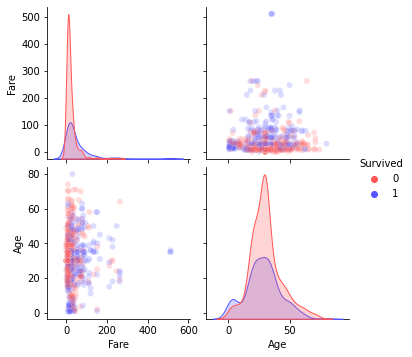

In [9]:
sns.pairplot(data[['Fare',  'Age', 'Survived']], hue = 'Survived', plot_kws = {'alpha' : .2}, palette = 'seismic_r')
plt.show

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

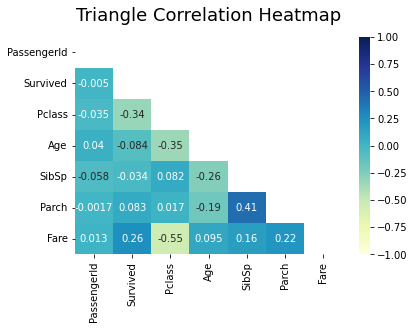

In [10]:
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(data.corr(), annot = True, mask=mask, cmap="YlGnBu",vmin=-1, vmax=1)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

# 2. ML

In [11]:
data = data.drop(['PassengerId', 'Name', 'Ticket', 'name', 'surname'], axis = 1)
data_ohe = pd.get_dummies(data, drop_first=True)

data_id_test = data_test['PassengerId']

In [12]:
data_test = data_test.drop(['PassengerId', 'Name', 'Ticket', 'name', 'surname'], axis = 1)
data_test_ohe = pd.get_dummies(data_test, drop_first=True)

data_test_ohe = data_test_ohe.rename(columns={'status_Dona': 'status_Don'})
data_test_ohe[['status_Col','status_Countess' , 'status_Jonkheer', 'status_Lady', 'status_Major', 'status_Mlle', 'status_Mme','status_Ms', 'status_Sir' ]] = 0


data_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           418 non-null    int64  
 1   Age              418 non-null    float64
 2   SibSp            418 non-null    int64  
 3   Parch            418 non-null    int64  
 4   Fare             418 non-null    float64
 5   Sex_male         418 non-null    uint8  
 6   Embarked_Q       418 non-null    uint8  
 7   Embarked_S       418 non-null    uint8  
 8   status_Don       418 non-null    uint8  
 9   status_Dr        418 non-null    uint8  
 10  status_Master    418 non-null    uint8  
 11  status_Miss      418 non-null    uint8  
 12  status_Mr        418 non-null    uint8  
 13  status_Mrs       418 non-null    uint8  
 14  status_Ms        418 non-null    int64  
 15  status_Rev       418 non-null    uint8  
 16  status_Col       418 non-null    int64  
 17  status_Countess 

In [13]:
pd.DataFrame(data_id_test)

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [14]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         889 non-null    int64  
 1   Pclass           889 non-null    int64  
 2   Age              889 non-null    float64
 3   SibSp            889 non-null    int64  
 4   Parch            889 non-null    int64  
 5   Fare             889 non-null    float64
 6   Sex_male         889 non-null    uint8  
 7   Embarked_Q       889 non-null    uint8  
 8   Embarked_S       889 non-null    uint8  
 9   status_Col       889 non-null    uint8  
 10  status_Countess  889 non-null    uint8  
 11  status_Don       889 non-null    uint8  
 12  status_Dr        889 non-null    uint8  
 13  status_Jonkheer  889 non-null    uint8  
 14  status_Lady      889 non-null    uint8  
 15  status_Major     889 non-null    uint8  
 16  status_Master    889 non-null    uint8  
 17  status_Miss     

In [15]:
data_features = data_ohe.drop(['Survived'], axis = 1)
data_target = data_ohe['Survived']

features_train, features_valid, target_train, target_valid = train_test_split(
        data_features, data_target, test_size=0.25, random_state=12345) 

numeric = ['Fare', 'SibSp', 'Age', 'Parch']
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric]) 
features_valid[numeric] = scaler.fit_transform(features_valid[numeric]) 
data_test_ohe[numeric] = scaler.fit_transform(data_test_ohe[numeric]) 

import warnings
warnings.filterwarnings('ignore')

print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(data_test_ohe.shape)

warnings.filterwarnings('ignore')

(666, 24) (666,)
(223, 24) (223,)
(418, 24)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [16]:
scores = []
def search(model, parametrs, model_name):
    search = RandomizedSearchCV(model, parametrs, cv=5)
    search.fit(features_train, target_train)
    predicted_valid = search.predict(features_valid)
    print(model_name, search.best_params_)
    scores.append(pd.Series({
        'Estimator' : model_name, 
        'best_parameter': search.best_params_, 
        'best_score': search.best_score_
    }))
    return search.best_params_
    warnings.filterwarnings('ignore')

decision_param = search(DecisionTreeClassifier(random_state = 12345),{'max_depth': range (1,13, 1),'criterion': ['gini', 'entropy']} , 'DecisionTreeClassifier')

param_random = search(RandomForestClassifier(random_state = 12345),{  
              'n_estimators': range (1, 51, 5),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2),
              'criterion': ['gini', 'entropy'] ,
              'max_features': ['auto', 'sqrt', 'log2']} , 'RandomForestClassifier')

param_XGBClassifier = search(XGBClassifier(random_state = 12345), { 'eval_metric' : ['mlogloss'],
    'max_depth': range (1,13, 1),
    'n_estimators': range(1, 400, 20)}, 'XGBClassifier')
warnings.filterwarnings('ignore')

param_kn = search(KNeighborsClassifier(), {
    'n_neighbors': range (1,20, 1), 'weights': ['distance', 'uniform']
    }, 'KNeighborsClassifier')

search(AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 12345)),{
    'base_estimator__criterion' : ["gini", "entropy"],
    "base_estimator__splitter" :   ["best", "random"],
    }, 'AdaBoostClassifier' )

DecisionTreeClassifier {'max_depth': 7, 'criterion': 'entropy'}
RandomForestClassifier {'n_estimators': 46, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 11, 'criterion': 'gini'}
XGBClassifier {'n_estimators': 81, 'max_depth': 2, 'eval_metric': 'mlogloss'}
KNeighborsClassifier {'weights': 'uniform', 'n_neighbors': 5}
AdaBoostClassifier {'base_estimator__splitter': 'random', 'base_estimator__criterion': 'entropy'}


{'base_estimator__splitter': 'random', 'base_estimator__criterion': 'entropy'}

In [17]:
results = pd.concat(scores, axis=1).T.set_index('Estimator')   
results

,best_parameter,best_score
Estimator,,
DecisionTreeClassifier,"{'max_depth': 7, 'criterion': 'entropy'}",0.839322
RandomForestClassifier,"{'n_estimators': 46, 'min_samples_split': 6, '...",0.837807
XGBClassifier,"{'n_estimators': 81, 'max_depth': 2, 'eval_met...",0.852834
KNeighborsClassifier,"{'weights': 'uniform', 'n_neighbors': 5}",0.830345
AdaBoostClassifier,"{'base_estimator__splitter': 'random', 'base_e...",0.812299


RandomForestClassifier
auc_roc:  0.8258


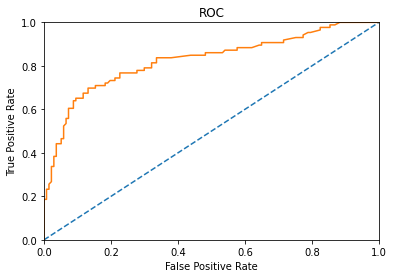

XGBClassifier
auc_roc:  0.837


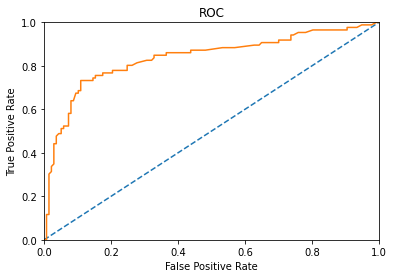

KNeighborsClassifier
auc_roc:  0.8336


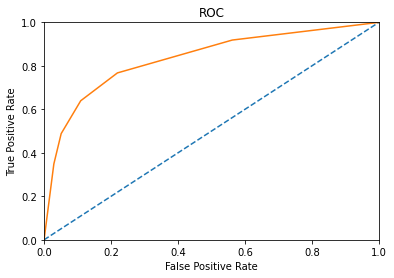

DecisionTreeClassifier
auc_roc:  0.7741


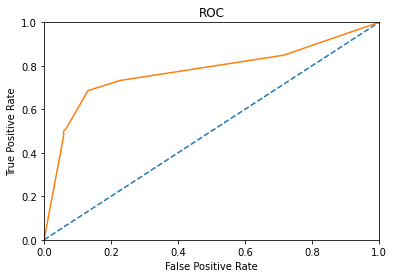

In [18]:
def roc(model, model_name):
  model.fit(features_train, target_train)
  probabilities_valid = model.predict_proba(features_valid)
  probabilities_one_valid = probabilities_valid[:, 1]
  print(model_name)
  print('auc_roc: ', roc_auc_score(target_valid, probabilities_one_valid).round(4))
  fpr, tpr, thresholds = roc_curve(target_valid,probabilities_one_valid)
  
  plt.figure()
  plt.plot([0, 1], [0, 1], linestyle = '--')
  plt.plot(fpr, tpr)
  plt.xlim([0,1]) 
  plt.ylim([0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.show()

roc(RandomForestClassifier( **param_random, random_state = 12345), 'RandomForestClassifier')

roc(XGBClassifier(**param_XGBClassifier, random_state = 12345), 'XGBClassifier')

roc(KNeighborsClassifier(**param_kn), 'KNeighborsClassifier')

roc(DecisionTreeClassifier(**decision_param, random_state = 12345), 'DecisionTreeClassifier')

In [19]:
model = RandomForestClassifier( **param_random, random_state = 12345)
model.fit(features_train, target_train)

predicts = model.predict(data_test_ohe)

output = pd.DataFrame({'PassengerId': data_id_test, 'Survived': predicts})

output.to_csv('my_submission_titanik.csv', index=False)
print(output)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!
